## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [61]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from random import sample
from itertools import chain
from sklearn.model_selection import train_test_split

import cv2
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [15]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
79328,00019479_006.png,Cardiomegaly|Effusion|Nodule,6,19479,33,F,PA,2522,2991,0.143,0.143,NaN,/data/images_009/images/00019479_006.png
99932,00026466_001.png,No Finding,1,26466,39,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026466_001.png
64352,00015879_001.png,No Finding,1,15879,21,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015879_001.png


In [16]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]

In [17]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df['nb_diseases'] = 0

all_xray_df['nb_diseases'] = all_xray_df.apply(
    lambda row: 0 if row['Finding Labels'] == 'No Finding' else len(row['Finding Labels'].split('|'))
    , axis=1)

all_xray_df.head()


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,nb_diseases
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [18]:
all_xray_df.path

0         /data/images_001/images/00000001_000.png
1         /data/images_001/images/00000001_001.png
2         /data/images_001/images/00000001_002.png
3         /data/images_001/images/00000002_000.png
4         /data/images_001/images/00000003_000.png
                            ...                   
112115    /data/images_012/images/00030801_001.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 112104, dtype: object

In [19]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = [str(int(x)) for x in all_xray_df['Pneumonia']]
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,nb_diseases,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


from EDA, we know that the number of cases of pneumonia is 1294.

In [20]:
all_xray_df[all_xray_df['pneumonia_class'] == "1"].shape[0]*100/all_xray_df[all_xray_df['pneumonia_class'] == "0"].shape[0]

1.2920830547373368

## Create your training and testing data:

In [21]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    # We need equal amount of positive and negative data in our training set
    # if there were any significant correlations with other diseases 
    # we should take that into consideration in the no pneumonia cases 
    p_inds = train_data[train_data['pneumonia_class']=="1"].index.tolist()
    np_inds = train_data[train_data['pneumonia_class']=="0"].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    # make sure to have positive points in the validation set with same proportion as real data 
    # The prevalence of pneumonia cases is about 1%
    p_inds = val_data[val_data['pneumonia_class']=="1"].index.tolist()
    np_inds = val_data[val_data['pneumonia_class']=="0"].index.tolist()

    p_sample = sample(p_inds,int(round(len(np_inds) / 100)))
    val_data = val_data.loc[p_sample + np_inds]

    return train_data, val_data

In [22]:
train_data, val_data = create_splits(all_xray_df)

In [23]:
len(val_data)

22356

In [24]:
len(train_data)

2288

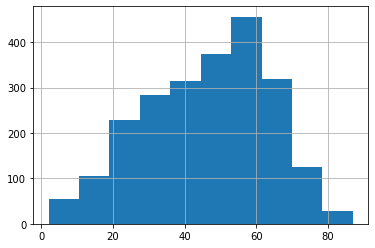

In [26]:
train_data["Patient Age"].hist()

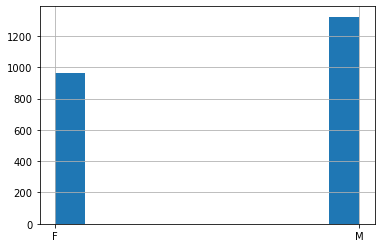

In [27]:
train_data["Patient Gender"].hist()

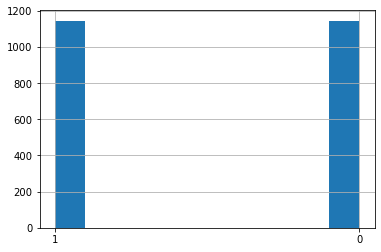

In [28]:
train_data["pneumonia_class"].hist()

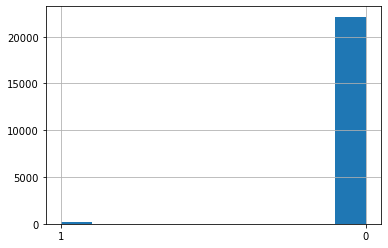

In [30]:
val_data["pneumonia_class"].hist()

Our final training and validation split does not respect 80-20 because of the few number of pneumonia points.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [31]:
IMG_SIZE = (224, 224)

from scipy.ndimage.filters import gaussian_filter
from skimage import color
import cv2

class CustomDataGenerator(ImageDataGenerator):
    def __init__(self, 
                h_kernel_size: int = None, 
                v_kernel_size: int = None, 
                **kwargs) -> None:
        
        super().__init__(
          preprocessing_function=self.actions,
          **kwargs)
        
        self.h_kernel_size = h_kernel_size
        self.v_kernel_size = v_kernel_size

    def actions(self, image: np.ndarray) -> np.ndarray:
        # Applies the transformation 
        action_list = ['horizontal_motion_blur', 'none']

        # Random values to select an operation
        operations = np.random.random(2).tolist()
        maximum = operations.index(max(operations))
        op = action_list[maximum]

        if op == 'horizontal_motion_blur':
            image = self.horizontal_motion_blur(image)
        else:
            return image

        return image
    
    def horizontal_motion_blur(self, image: np.ndarray) -> np.ndarray:
        '''
          Horizontal motion blur that may happen if a patient moves during the x-ray imaging. 
        '''
        if self.h_kernel_size == None:
            return image

        kernel_h = np.zeros((self.h_kernel_size, self.h_kernel_size))

        # Fill the middle row with ones.
        kernel_h[int((self.h_kernel_size - 1)/2), :] = np.ones(self.h_kernel_size)

        # Normalize.
        kernel_h /= self.h_kernel_size

        # Apply the horizontal kernel.
        horizonal_mb = cv2.filter2D(image, -1, kernel_h)
        horizonal_mb = np.reshape(horizonal_mb, image.shape)

        return horizonal_mb
    
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    
    my_idg = CustomDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  h_kernel_size=5,
                                  height_shift_range = 0.1, 
                                  width_shift_range = 0.1, 
                                  rotation_range = 20, 
                                  shear_range = 0.1,
                                  zoom_range=0.1
                                )
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(vargs)
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = "path",
                                         y_col = "pneumonia_class",
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 16
                                         )

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 250, # needs to be more than 100 because of the 1% prevalence 
                                 shuffle=True
                                         )
    
    return val_gen

In [32]:
train_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,nb_diseases,pneumonia_class
86605,00021369_002.png,Pneumonia,2,21369,38,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
41957,00010805_042.png,Pneumonia,42,10805,9,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
21222,00005673_003.png,Pneumonia,3,5673,41,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
59681,00014731_016.png,Emphysema|Mass|Pneumonia|Pneumothorax,16,14731,54,M,PA,2878,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4,1
13628,00003528_037.png,Infiltration|Pneumonia,37,3528,46,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85565,00021095_000.png,No Finding,0,21095,29,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
80191,00019707_010.png,Effusion,10,19707,58,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
10585,00002740_001.png,No Finding,1,2740,13,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
71546,00017625_004.png,No Finding,4,17625,11,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


In [33]:
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2288 validated image filenames belonging to 2 classes.
Found 22356 validated image filenames belonging to 2 classes.


In [34]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

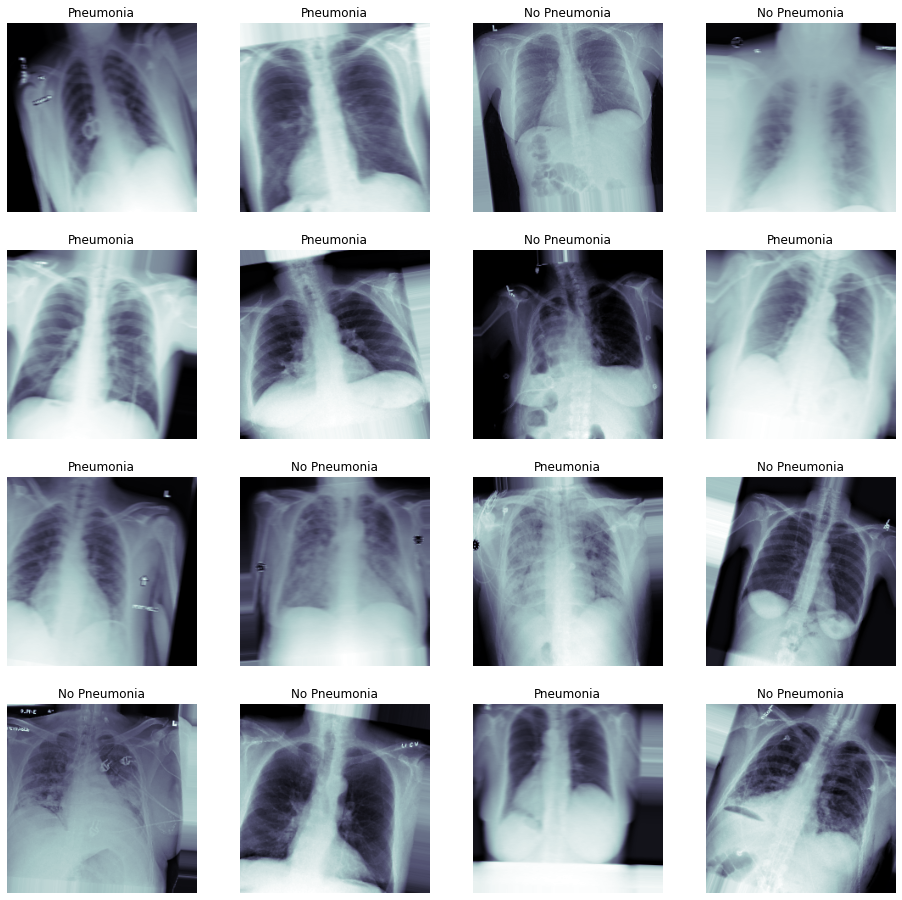

In [35]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [36]:
def load_pretrained_model(vargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    return vgg_model


In [37]:
load_pretrained_model(None)

In [38]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_my_model(vargs):
    my_model = Sequential()
    vgg_model = load_pretrained_model(vargs)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    for layer in vgg_model.layers[:-1]:
        layer.trainable = False
        
    my_model.add(vgg_model)
    
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())


    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(4096, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.2))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.2))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))
    
    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', f1_m]
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [39]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
my_model = build_my_model(None)
print(my_model)
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',#CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', #SAME_AS_METRIC_CHOSEN_ABOVE
                      mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
                      patience=10)

callbacks_list = [checkpoint, early]

In [40]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

### Start training! 

In [41]:
## train your model

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
143/143 [==============================] - 68s 474ms/step - loss: 0.7070 - binary_accuracy: 0.5363 - f1_m: 0.4880 - val_loss: 0.7821 - val_binary_accuracy: 0.3600 - val_f1_m: 0.0290
Epoch 2/10
143/143 [==============================] - 59s 416ms/step - loss: 0.6862 - binary_accuracy: 0.5568 - f1_m: 0.5295 - val_loss: 0.7907 - val_binary_accuracy: 0.4080 - val_f1_m: 0.0296
Epoch 3/10
143/143 [==============================] - 61s 429ms/step - loss: 0.6770 - binary_accuracy: 0.5822 - f1_m: 0.5732 - val_loss: 0.3915 - val_binary_accuracy: 0.9480 - val_f1_m: 0.1354
Epoch 4/10
143/143 [==============================] - 60s 420ms/step - loss: 0.6878 - binary_accuracy: 0.5822 - f1_m: 0.5394 - val_loss: 0.6094 - val_binary_accuracy: 0.6560 - val_f1_m: 0.0399
Epoch 5/10
143/143 [==============================] - 60s 421ms/step - loss: 0.6704 - binary_accuracy: 0.5966 - f1_m: 0.5708 - val_loss: 0.5948 - val_binary_accuracy: 0.6840 - val_f1_m: 0.0420
Epoch 6/10
143/143 [===============

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [42]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(val_gen, verbose = True)   

90/90 [==============================] - 410s 5s/step


In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
def plot_auc(t_y, p_y):
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return thresholds

def plot_pr_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def plot_f1t(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1=2*(precision*recall)/(precision+recall)
    c_ax.plot(f1[0:len(thresholds)], thresholds, label = 'f1_score vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1_score')
    
## what other performance statistics do you want to include here besides AUC?

def get_statistics(t_y, p_y, threshold):
    
    tn, fp, fn, tp = confusion_matrix(t_y, p_y).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1_score = (2 * precision * recall) / (precision + recall)
    
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    
    return [threshold, sensitivity, specificity, precision, recall, f1_score, accuracy]
    
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    

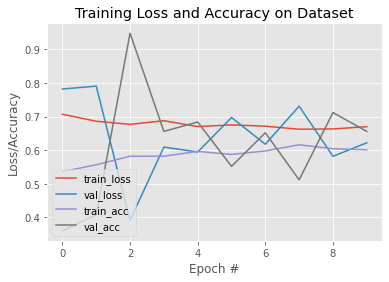

In [44]:
## plot figures
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [45]:
pred_Y = pred_Y.flatten().tolist()

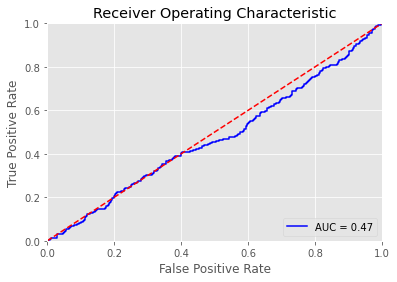

In [46]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

thresholds = plot_auc(val_gen.labels, pred_Y)

No handles with labels found to put in legend.


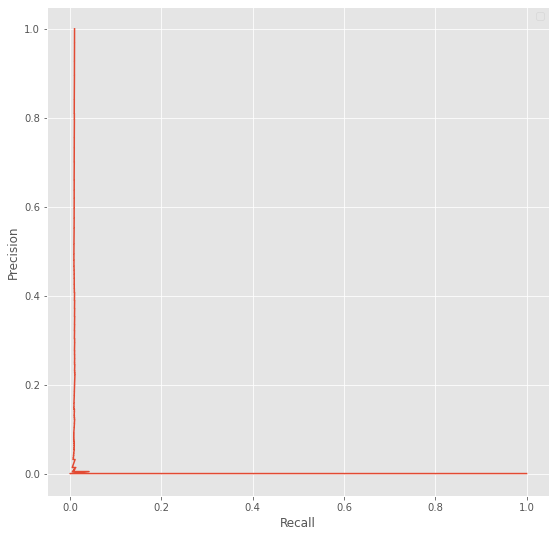

In [47]:
plot_pr_curve(val_gen.labels, pred_Y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


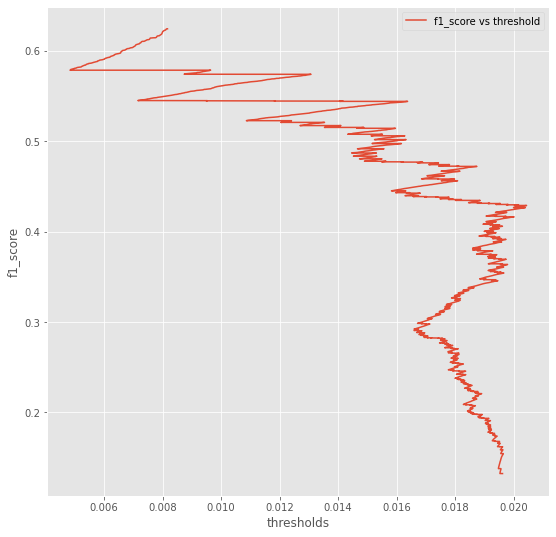

In [48]:
plot_f1t(val_gen.labels, pred_Y)

In [49]:
statistics = []

for threshold in np.arange(0.0, 1.0, 0.01):
    pred_Y_ = (pred_Y >= threshold)
    statistics.append(get_statistics(val_gen.labels, pred_Y_, threshold))

df = pd.DataFrame(statistics,
                     columns=['Threshold', 'Sensitivity', 'Spec.', 'Precision', 'Recall', 'F1_score', 'Accuracy'])

df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


,Threshold,Sensitivity,Spec.,Precision,Recall,F1_score,Accuracy
0,0.00,1.0,0.0,0.009885,1.0,0.019577,0.009885
1,0.01,1.0,0.0,0.009885,1.0,0.019577,0.009885
2,0.02,1.0,0.0,0.009885,1.0,0.019577,0.009885
3,0.03,1.0,0.0,0.009885,1.0,0.019577,0.009885
4,0.04,1.0,0.0,0.009885,1.0,0.019577,0.009885
...,...,...,...,...,...,...,...
95,0.95,0.0,1.0,NaN,0.0,NaN,0.990115
96,0.96,0.0,1.0,NaN,0.0,NaN,0.990115
97,0.97,0.0,1.0,NaN,0.0,NaN,0.990115
98,0.98,0.0,1.0,NaN,0.0,NaN,0.990115


In [50]:
df[df.F1_score == max(df.F1_score)]

,Threshold,Sensitivity,Spec.,Precision,Recall,F1_score,Accuracy
13,0.13,1.0,0.001852,0.009904,1.0,0.019613,0.011719


In [51]:
df[df.Recall == max(df.Recall)]

,Threshold,Sensitivity,Spec.,Precision,Recall,F1_score,Accuracy
0,0.00,1.0,0.000000,0.009885,1.0,0.019577,0.009885
1,0.01,1.0,0.000000,0.009885,1.0,0.019577,0.009885
2,0.02,1.0,0.000000,0.009885,1.0,0.019577,0.009885
3,0.03,1.0,0.000000,0.009885,1.0,0.019577,0.009885
4,0.04,1.0,0.000000,0.009885,1.0,0.019577,0.009885
5,0.05,1.0,0.000000,0.009885,1.0,0.019577,0.009885
6,0.06,1.0,0.000000,0.009885,1.0,0.019577,0.009885
7,0.07,1.0,0.000000,0.009885,1.0,0.019577,0.009885
8,0.08,1.0,0.000000,0.009885,1.0,0.019577,0.009885
9,0.09,1.0,0.000000,0.009885,1.0,0.019577,0.009885


In [52]:
chosen_threshold = 0.13
pred_Y_ = (pred_Y >= threshold)

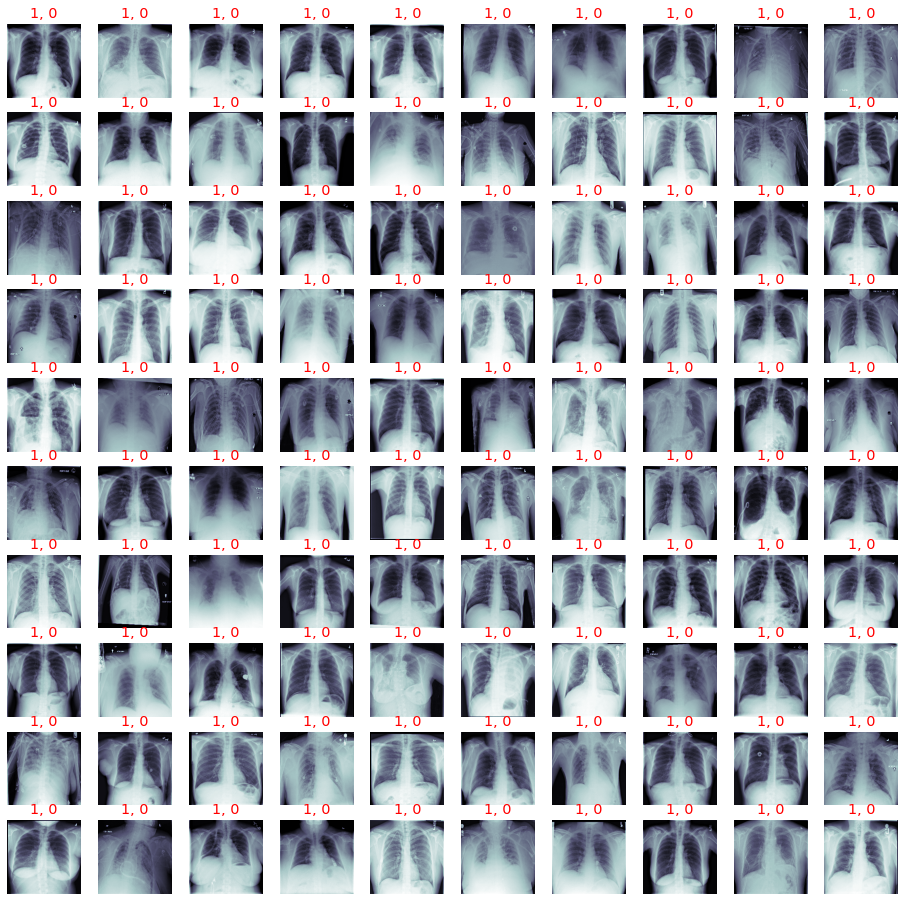

In [53]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX, val_gen.labels, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y_[i] > chosen_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0', color="red")
    else:
        if pred_Y_[i] > chosen_threshold: 
            c_ax.set_title('0, 1', color="red")
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [54]:
confusion_matrix(val_gen.labels, pred_Y_)

array([[22135,     0],
       [  221,     0]])

In [55]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)